Loading required package: dplyr


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: colorspace

Loading required package: khroma

Loading required package: ggplot2

Loading required package: ggpattern

Loading required package: reshape2

Loading required package: tidyverse

── Attaching core tidyverse packages ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ lubridate 1.9.2     ✔ tibble    3.2.1
✔ purrr     1.0.1     ✔ tidyr     1.3.0
✔ readr     2.1.4     
── Conflicts ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_confl

[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[[4]]
[1] TRUE

[[5]]
[1] TRUE

[[6]]
[1] TRUE

[[7]]
[1] TRUE

[[8]]
[1] TRUE

[[9]]
[1] TRUE

[[10]]
[1] TRUE

[[11]]
[1] TRUE

[[12]]
[1] TRUE

[[13]]
[1] TRUE

[[14]]
[1] TRUE

[[15]]
[1] TRUE

[[16]]
[1] TRUE

[[17]]
[1] TRUE

[[18]]
[1] TRUE

[[19]]
[1] TRUE

[[20]]
[1] TRUE

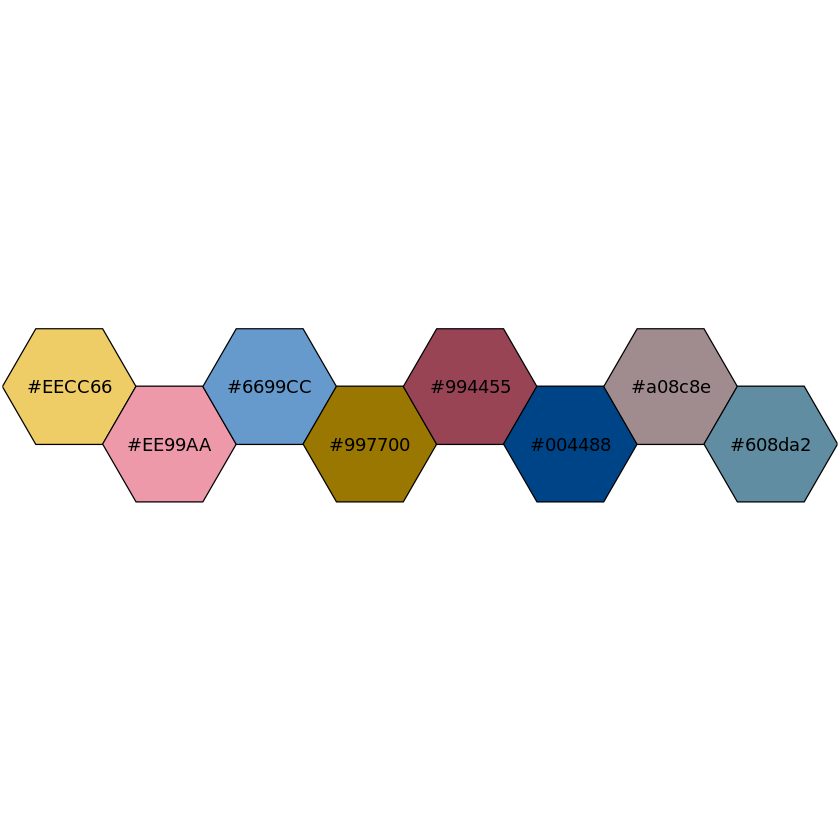

In [1]:
f_func <- "../functions.ipynb"
eval(parse(text = system2('jupyter', c('nbconvert', f_func, '--to=script', '--stdout'), stdout = TRUE)))
f_path <- "../dirs.ipynb"
eval(parse(text = system2('jupyter', c('nbconvert', f_path, '--to=script', '--stdout'), stdout = TRUE)))
f_cols <- "../cols.ipynb"
eval(parse(text = system2('jupyter', c('nbconvert', f_cols, '--to=script', '--stdout'), stdout = TRUE)))

In [2]:
Fungi_RPM <- readRDS(paste0(INT_SPL, "Fungi_RPM.Rdata"))
Asp_genus_RPM <- readRDS(paste0(INT_SPL, "Asp_genus_RPM.Rdata"))
Asp_fum_RPM <- readRDS(paste0(INT_SPL, "Asp_fum_RPM.Rdata"))

Fungi_count <- readRDS(paste0(INT_SPL, "Fungi_count.Rdata"))
Asp_genus_count <- readRDS(paste0(INT_SPL, "Asp_genus_count.Rdata"))
Asp_fum_count <- readRDS(paste0(INT_SPL, "Asp_fum_count.Rdata"))
total_read_count <- readRDS(paste0(INT_SPL, "total_read_count.Rdata"))

In [3]:
Fungal_RPM_df <- Fungi_RPM[[wright_threshold]] %>% 
    melt(varnames = c("db", "sample_id"), value.name = "value") %>%  
    mutate(name = "Fungi") %>% 
    filter(db %in% dbs_sel_min)
Asp_genus_RPM_df <- Asp_genus_RPM[[wright_threshold]] %>% 
    melt(varnames = c("db", "sample_id"), value.name = "value") %>%  
    mutate(name = "Aspergillus") %>% 
    filter(db %in% dbs_sel_min)

df_RPM <- rbind(Fungal_RPM_df) %>%
    mutate(origin = ifelse(grepl(sample_id, pattern = "^A") & grepl(sample_id, pattern = "asp"), yes = "IPA samples",
                    ifelse(grepl(sample_id, pattern = "^A") & grepl(sample_id, pattern = "ctrl"), yes = "Internal controls",
                    ifelse(grepl(sample_id, pattern = "^H"), yes = "external controls", 
                    ifelse(grepl(sample_id, pattern = "^N"), yes = "controls", no = NA)))))  %>% 

    mutate(sample_short = str_replace(sample_id, str_sub(sample_id, 1, 3), "")) %>% 
    mutate(sample = ifelse(grepl(sample_id, pattern = "[0-9]B[a-z]"), yes = "BAL", 
                  ifelse(grepl(sample_id, pattern = "[0-9]P[a-z]"), yes = "plasma", no = "control")))  %>% 
    mutate(type = ifelse(grepl(sample_id, pattern = "K$"), yes = "ds-cfDNA", 
                  ifelse(grepl(sample_id, pattern = "P$"), yes = "ds-wcDNA", no = "ss-cfDNA"))) %>% 
    mutate(sample_type = paste(sample, type))  %>% 
    mutate(origin = fct_relevel(origin, c("IPA samples","Internal controls","external controls", "controls")))  %>% 
    mutate(sample_type = fct_relevel(sample_type, c("plasma ds-cfDNA", "plasma ss-cfDNA", 
                                                    "BAL ds-cfDNA", "BAL ss-cfDNA", 
                                                    "BAL ds-wcDNA")))  %>% 
    mutate(type = fct_relevel(type, c("ss-cfDNA", "ds-cfDNA", "ds-wcDNA"))) %>% 
    filter(origin != "controls")  %>% 
    filter(origin != "Internal controls")  %>% 
    mutate(sample_sh = substr(sample_id, 1, 3))  %>% 
    mutate(sample_sh = ifelse(grepl(sample_id, pattern = "VAL"), paste0(sample_sh, "val"), sample_sh)) %>% 
    filter(sample_id != "A05PaspVAL") %>% 
    mutate(sample_short = str_sub(sample_id, 1, 3)) %>% 
    filter(sample_short %nin% c("A11", "A12", "A13", "A16"))

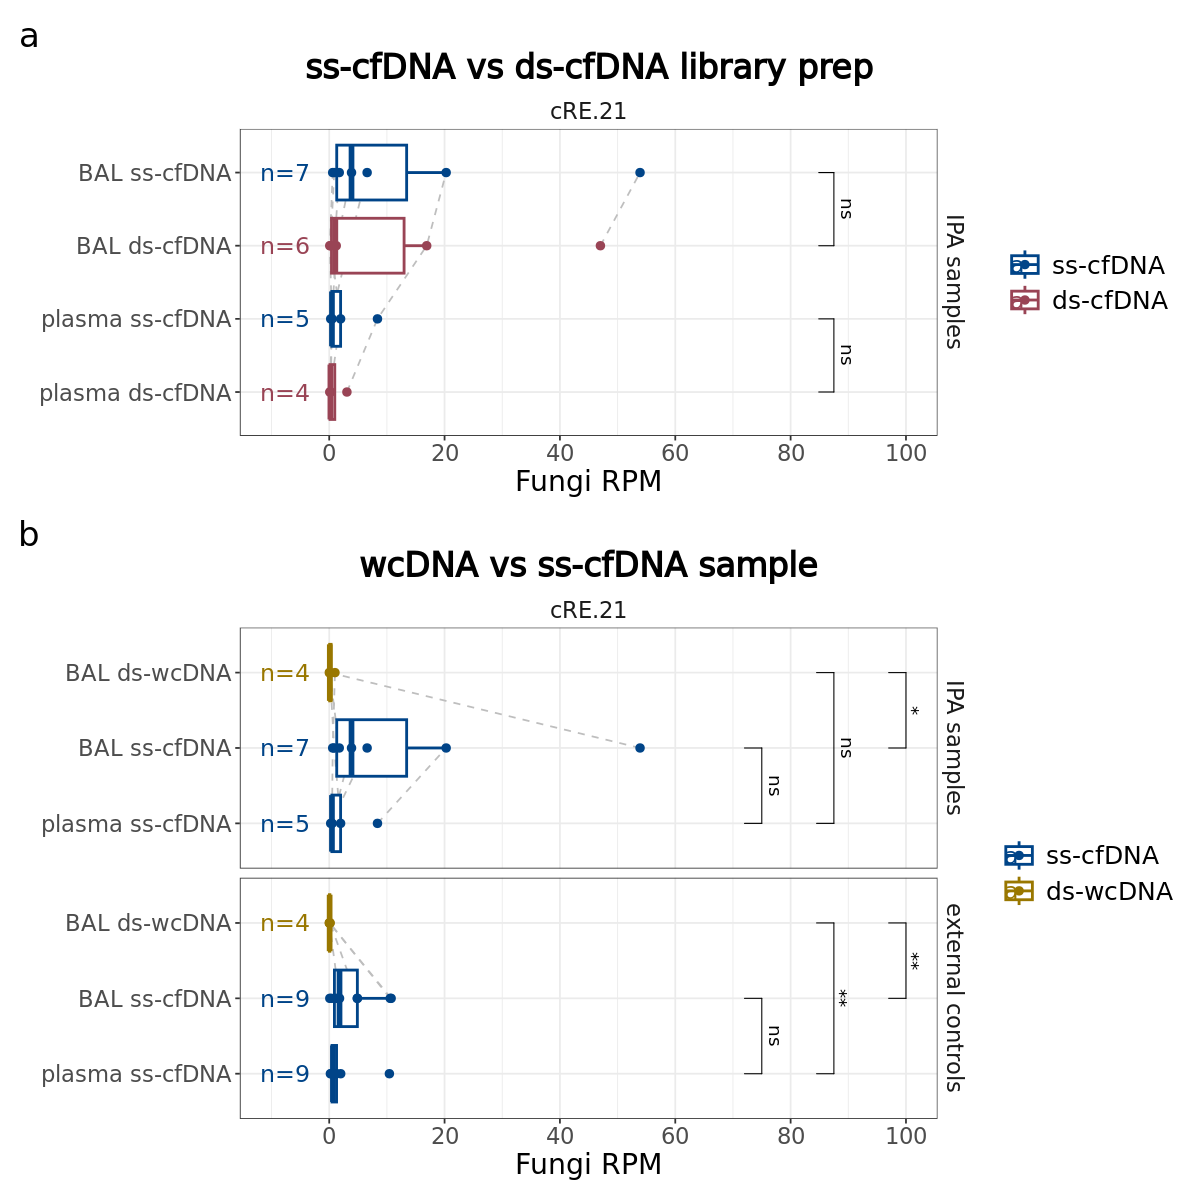

In [4]:
my_comp_prep <- list(c("plasma ds-cfDNA", "plasma ss-cfDNA"),
                c("BAL ds-cfDNA", "BAL ss-cfDNA"))
my_comp_specimen <- list(c("BAL ss-cfDNA", "plasma ss-cfDNA"), 
                 c("BAL ds-wcDNA", "plasma ss-cfDNA"),                  
                c("BAL ds-wcDNA", "BAL ss-cfDNA"))

stat.test <- compare_means(as.data.frame(df_RPM), 
                           formula = value~sample_type, group.by = c("db","name", "origin"), 
                           method = "wilcox.test",
                           p.adjust.method = "bonferroni") %>% 
    mutate(db = ifelse(db == "EPRSc2", yes = "cRE.21", no = as.character(db))) %>% 
    mutate(db = ifelse(db == "EPRSFv64MCAspDM", yes = "dREM.260", no = as.character(db)))
stat.test$plot_pvalue <- round(stat.test$p, digits = 3)

stat.test_prep <- stat.test %>%
    filter(origin == "IPA samples") %>% 
    filter(group1 %in% my_comp_prep[[1]] & group2 %in% my_comp_prep[[1]] | 
           group1 %in% my_comp_prep[[2]] & group2 %in% my_comp_prep[[2]] ) %>% 
    filter(db %in% c("cRE.21")) 

stat.test_specimen <- stat.test %>%
    filter(group1 %in% my_comp_specimen[[1]] & group2 %in% my_comp_specimen[[1]] | 
           group1 %in% my_comp_specimen[[2]] & group2 %in% my_comp_specimen[[2]] | 
           group1 %in% my_comp_specimen[[3]] & group2 %in% my_comp_specimen[[3]] ) %>% 
    filter(db %in% c("cRE.21")) 

fig_RPM_prep <- df_RPM %>% 
    filter(origin == "IPA samples") %>% 
    filter(db %in% dbs_sel_min) %>%
    filter(!grepl(sample_type, pattern = "wcDNA")) %>% 
    mutate(db = ifelse(db == "EPRSc2", yes = "cRE.21", no = as.character(db))) %>% 
    mutate(db = ifelse(db == "EPRSFv64MCAspDM", yes = "dREM.260", no = as.character(db))) %>% 
    filter(db == "cRE.21") %>% 
    ggplot(., aes(x=sample_type, y=value, color = type)) + 
        geom_line(aes(x = sample_type, y = value, group = sample_sh), color = "grey", linetype = "dashed") + 
        geom_boxplot(aes(x = sample_type, y=value, fill = type), lwd=0.8, fill = "white") + 
        geom_point(aes(x = sample_type, y=value, col = type), size = 2) + 
        stat_pvalue_manual(stat.test_prep, y.position = rep(87.5), coord.flip = TRUE,
                           label = "p.signif",remove.bracket = FALSE) +
        facet_grid(rows = vars(origin), cols = vars(db), space = "free", scales = "free") + 
        scale_color_manual(values = c("ss-cfDNA" = colors_mc[6], 
                                      "ds-cfDNA" = colors_mc[5], 
                                      "ds-wcDNA" = colors_mc[4])) + 
        theme_bw() +
        theme(strip.background=element_rect(fill="white", color = "white"), 
              strip.text.y.right = element_text(), 
              axis.title.y=element_blank(), legend.title=element_blank()) + 
        ylab("Fungi RPM") +
        scale_y_continuous(limits=c(-10, 100), breaks = seq(0,100,20)) +
        geom_text(aes(label=paste0("n=", after_stat(count))), y=-12, stat='count', size=5, hjust = 0) +
        coord_flip()+ ggtitle("ss-cfDNA vs ds-cfDNA library prep")

fig_RPM_specimen <- df_RPM %>% 
    filter(db %in% dbs_sel_min) %>%
    filter(!grepl(sample_type, pattern = "ds-cfDNA")) %>% 
    mutate(db = ifelse(db == "EPRSc2", yes = "cRE.21", no = as.character(db))) %>% 
    mutate(db = ifelse(db == "EPRSFv64MCAspDM", yes = "dREM.260", no = as.character(db))) %>%      
    filter(db == "cRE.21") %>% 
    ggplot(., aes(x=sample_type, y=value, color = type)) + 
        geom_line(aes(x = sample_type, y = value, group = sample_sh), color = "grey", linetype = "dashed") + 
        geom_boxplot(aes(x = sample_type, y=value, fill = type), lwd=0.8, fill = "white") + 
        geom_point(aes(x = sample_type, y=value, col = type), size = 2) + 
        geom_text(aes(label=paste0("n=", after_stat(count))), y=-12, stat='count', size=5, hjust = 0) +
        scale_color_manual(values = c("ss-cfDNA" = colors_mc[6], 
                                      "ds-cfDNA" = colors_mc[5], 
                                      "ds-wcDNA" = colors_mc[4])) + 
        stat_pvalue_manual(stat.test_specimen, y.position = rep(c(75,87.5,100),2), coord.flip = TRUE,
                           label = "p.signif",remove.bracket = FALSE) +
        facet_grid(rows = vars(origin), cols = vars(db), space = "free", scales = "free") + 
        scale_alpha_manual(values = c(0.3, 1)) +
        theme_bw() +
        theme(strip.background=element_rect(fill="white", color = "white"), 
              strip.text.y.right = element_text(), 
              axis.title.y=element_blank(), legend.title=element_blank()) + 
        ylab("Fungi RPM") +
        scale_y_continuous(limits=c(-10, 100), breaks = seq(0,100,20))+
        coord_flip() + ggtitle("wcDNA vs ss-cfDNA sample")

options(repr.plot.width=10, repr.plot.height=10)
Fig4 <- 
    fig_RPM_prep + fig_RPM_specimen + 
        plot_layout(ncol = 1, heights = c(1,1.6)) &
        plot_annotation(tag_levels = 'a') &
        guides(size = 30) & 
        theme(legend.position='right', legend.justification='center', legend.direction = 'vertical',
            legend.key.size = unit(0.75, 'cm'), legend.key.height = unit(0.75, 'cm'), legend.key.width = unit(0.75, 'cm'), 
            text = element_text(size = 17), legend.text = element_text(size = 15, colour = "black"),
            plot.title = element_text(size = 20, hjust = 0.5, face = "bold"), 
            plot.subtitle = element_text(size = 17, hjust = 0.5))

Fig4

ggsave("../../output/figures/Fig4_R.png", 
       Fig4, width = 10, height = 10)
ggsave("../../output/figures/Fig4_R.pdf", 
       Fig4, width = 10, height = 10)

In [6]:
###mentioned in results###
df_RPM %>% 
    filter(sample_id != "A05PaspVAL") %>% 
    mutate(sample_short = str_sub(sample_id, 1, 3)) %>% 
    filter(sample_short %nin% c("A11", "A12", "A13", "A16")) %>% 
    filter(origin == "IPA samples") %>% 
    filter(db %in% dbs_sel_min) %>%
    filter(!grepl(sample_type, pattern = "ds-cfDNA")) %>% 
    mutate(db = ifelse(db == "EPRSc2", yes = "cRE.21", no = as.character(db))) %>% 
    mutate(db = ifelse(db == "EPRSFv64MCAspDM", yes = "dREM.260", no = as.character(db))) %>% 
    filter(db == "cRE.21") %>% 
    group_by(sample_type) %>% 
    summarise(mean_RPM = mean(value)) %>%    
    filter(sample_type != "plasma ss-cfDNA")

print(paste("12.545690/2.306701 =", round(c(12.545690/2.306701), digits = 2)))


df_RPM %>% 
    filter(sample_id != "A05PaspVAL") %>% 
    mutate(sample_short = str_sub(sample_id, 1, 3)) %>% 
    filter(sample_short %nin% c("A11", "A12", "A13", "A16")) %>% 
    filter(origin == "IPA samples") %>% 
    filter(db %in% dbs_sel_min) %>%
    filter(!grepl(sample_type, pattern = "ds-cfDNA")) %>% 
    mutate(db = ifelse(db == "EPRSc2", yes = "cRE.21", no = as.character(db))) %>% 
    mutate(db = ifelse(db == "EPRSFv64MCAspDM", yes = "dREM.260", no = as.character(db))) %>% 
    filter(db == "cRE.21") %>% 
    group_by(sample_type) %>% 
    summarise(mean_RPM = mean(value)) %>%    
    filter(grepl(sample_type, pattern = "ss-cfDNA"))


sample_type,mean_RPM
<fct>,<dbl>
BAL ss-cfDNA,12.54569
BAL ds-wcDNA,0.30345


[1] "12.545690/2.306701 = 5.44"


sample_type,mean_RPM
<fct>,<dbl>
plasma ss-cfDNA,2.306701
BAL ss-cfDNA,12.545690


In [7]:
###mentioned in discussion of manuscript
df_RPM %>% 
    filter(db %in% dbs_sel_min) %>%
    filter(!grepl(sample_type, pattern = "ds-cfDNA")) %>% 
    mutate(db = ifelse(db == "EPRSc2", yes = "cRE.21", no = as.character(db))) %>% 
    mutate(db = ifelse(db == "EPRSFv64MCAspDM", yes = "dREM.260", no = as.character(db))) %>% 
    group_by(sample_type) %>% 
    summarise(max_RPM = max(value)) %>% 
    filter(sample_type == "BAL ds-wcDNA")

sample_type,max_RPM
<fct>,<dbl>
BAL ds-wcDNA,2.549661
